In [10]:
# Import the required libraries

import torch
import os
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn as nn
import math
import numpy as np
from natsort import natsorted
from PIL import Image
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

In [21]:
# Assign loss values
run_name    = "run1"
all_images  = os.listdir(f"Results/{run_name}")
gt_labels   = natsorted([image_dir for image_dir in all_images if image_dir[:2] == "GT"])
pred_labels = natsorted([image_dir for image_dir in all_images if image_dir[:3] == "Out"])

loss_func = torch.nn.L1Loss()
convert_tensor = transforms.ToTensor()

with open("file_to_category.pkl", "rb") as file:
    file_to_category = pickle.load(file)

category_losses = {}
file_name_to_loss = {}

for gt, pred in tqdm(zip(gt_labels, pred_labels)):

    image_name = gt[3:]

    # Load those images
    gt_image   = Image.open(f'Results/{run_name}/{gt}').convert("RGB") 
    pred_image = Image.open(f'Results/{run_name}/{pred}').convert("RGB")
    gt_image, pred_image = convert_tensor(gt_image), convert_tensor(pred_image)

    # Find out what category they belong to
    category = file_to_category[image_name]

    # Compare the loss between them
    loss = loss_func(gt_image, pred_image)

    # Save the loss statistics
    file_name_to_loss[image_name] = loss.item()

    if category in category_losses:
        category_losses[category] += [loss.item()]
    else:
        category_losses[category]  = [loss.item()]

total_loss = sum(list(file_name_to_loss.values()))
mean_loss  = np.mean(list(file_name_to_loss.values()))
best_loss  = min(list(file_name_to_loss.values()))
worst_loss = max(list(file_name_to_loss.values())) 

print("Dataset based statistics")
print(f"Total Loss: {total_loss}")
print(f"Mean Loss: {mean_loss}")
print(f"Best Loss: {best_loss}")
print(f"Worst Loss: {worst_loss}")

print(" ")
print("Class based statistics:")
for key in category_losses.keys():
    category_losses[key] = np.mean(category_losses[key])
    print(key, category_losses[key])

print(f"Mean loss: {np.mean(list(category_losses.values()))}")
print(f"STD of losses: {np.std(list(category_losses.values()))}")


188it [00:00, 539.97it/s]

Dataset based statistics
Total Loss: 90.29732989147305
Mean Loss: 0.48030494623123965
Best Loss: 0.04444795846939087
Worst Loss: 0.7907813191413879
 
Class based statistics:
airport_terminal 0.43954108442579
kitchen 0.5065115107731386
amusement_park 0.41148145496845245
living room 0.625232050816218
golf_course 0.43359009282929556
conference_room 0.4541122217973073
big 0.5810455896637656
populated 0.4254301324486732
public-entertainment 0.45998156163841486
living_room 0.4334976602759626
mountain 0.5138818422953287
house 0.31298037711530924
pasture 0.5076964178255626
skyscraper 0.355646156838962
work-home 0.4990642163902521
small 0.562636976892298
isolated 0.5498441204428672
playground 0.4506400734186172
badlands 0.466518759727478
Mean loss: 0.4731227526622996
STD of losses: 0.07405275549651387


In [23]:
# Get an ordering of the best and worst images
best_image_scores   = sorted(file_name_to_loss.items(), key = lambda x:x[1], reverse=False)
worst_image_scores  = sorted(file_name_to_loss.items(), key = lambda x:x[1], reverse=True)

image: sun_byofzufeigwrchdf.jpg loss: 0.04444795846939087
image: sun_akvgycniyttaeipg.jpg loss: 0.052708130329847336
image: sun_arooxbisltdzotno.jpg loss: 0.07610701769590378
image: sun_bcgskwhauninzvhk.jpg loss: 0.08158190548419952
image: sun_aciofoesudrskhdm.jpg loss: 0.1087438240647316
image: sun_bjlegoqryfjahpzn.jpg loss: 0.117281973361969
image: sun_banwlxzczuuxgcze.jpg loss: 0.11806800961494446
image: sun_bgadgwhqgnwuvinw.jpg loss: 0.11992770433425903
image: sun_bgjytsucreqesmlo.jpg loss: 0.12272519618272781


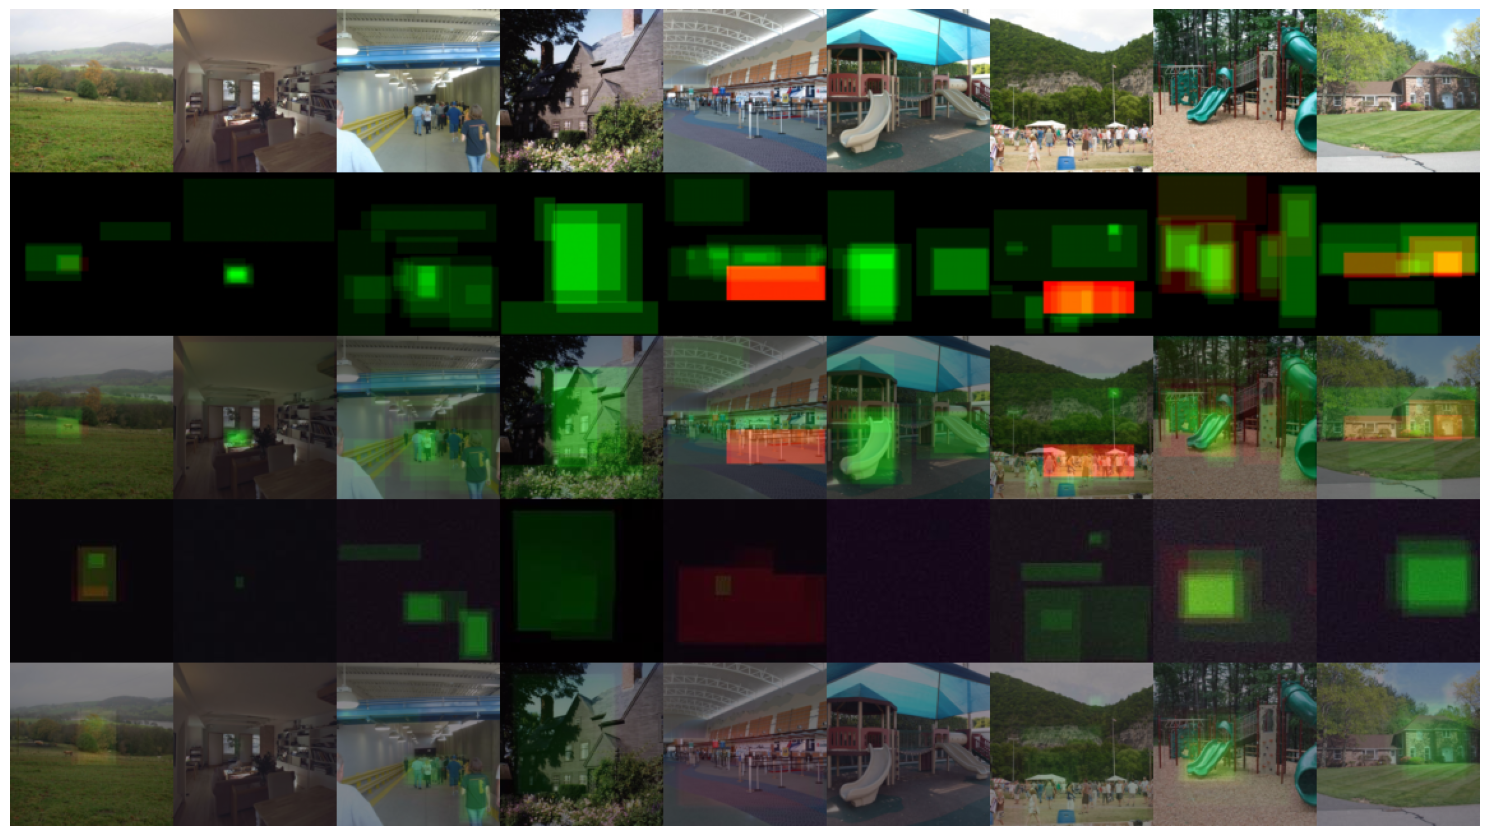

In [32]:
# Display boilerplate
figure = plt.figure(figsize=(15,15))
cols, rows = 9, 1

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(128, antialias=True),
    transforms.Normalize(0.5,0.5)
])


# Show the best
for i in range(cols):
    
    image_path   = best_image_scores[i][0]
    print(f"image: {best_image_scores[i][0]} loss: {best_image_scores[i][1]}")
    image        = image_transforms(Image.open(f"../VISCHEMA_PLUS/images/{image_path}").convert("RGB"))
    label        = image_transforms(Image.open(f"../VISCHEMA_PLUS/vms/{image_path}").convert("RGB"))
    output       = image_transforms(Image.open(f"Results/{run_name}/Out_{image_path}").convert("RGB"))

    image, label, output = image[None, :], label[None, :], output[None, :]

    ideal        = torch.add(image, label)/2
    output_cat   = torch.add(image, output)/2

    if i == 0:
        display = torch.cat([
            image.to("cpu"), 
            label.to("cpu"), 
            ideal.to("cpu").detach(), 
            output.to("cpu").detach(), 
            output_cat.to("cpu").detach()
            ], dim=2)
    else:

        display = torch.cat([
            display, 
            torch.cat([
                image.to("cpu"), 
                label.to("cpu"), 
                ideal.to("cpu").detach(), 
                output.to("cpu").detach(), 
                output_cat.to("cpu").detach()
                ], dim=2)
            ], dim = 3)

display = ((display +1 ) /2).clip(0,1)        
plt.axis("off")
plt.imshow(display[0].squeeze().permute(1, 2, 0)) 
plt.tight_layout()
plt.show()

image: sun_aijkdpqohzcmjsco.jpg loss: 0.7907813191413879
image: sun_byvdzprgynazwqcq.jpg loss: 0.7890352606773376
image: sun_bhltecqgovgxitsk.jpg loss: 0.777901828289032
image: sun_bbbhwpsfnpfubmfq.jpg loss: 0.7724167704582214
image: sun_bmhxlxfyhoejizbf.jpg loss: 0.7705094218254089
image: sun_bntjgmywduitzqsd.jpg loss: 0.7686851024627686
image: sun_aqedpjgbtyhobhhr.jpg loss: 0.7652027010917664
image: sun_bextbylysbvetkln.jpg loss: 0.7597706913948059
image: sun_asucakqszskyhtxv.jpg loss: 0.7573180198669434


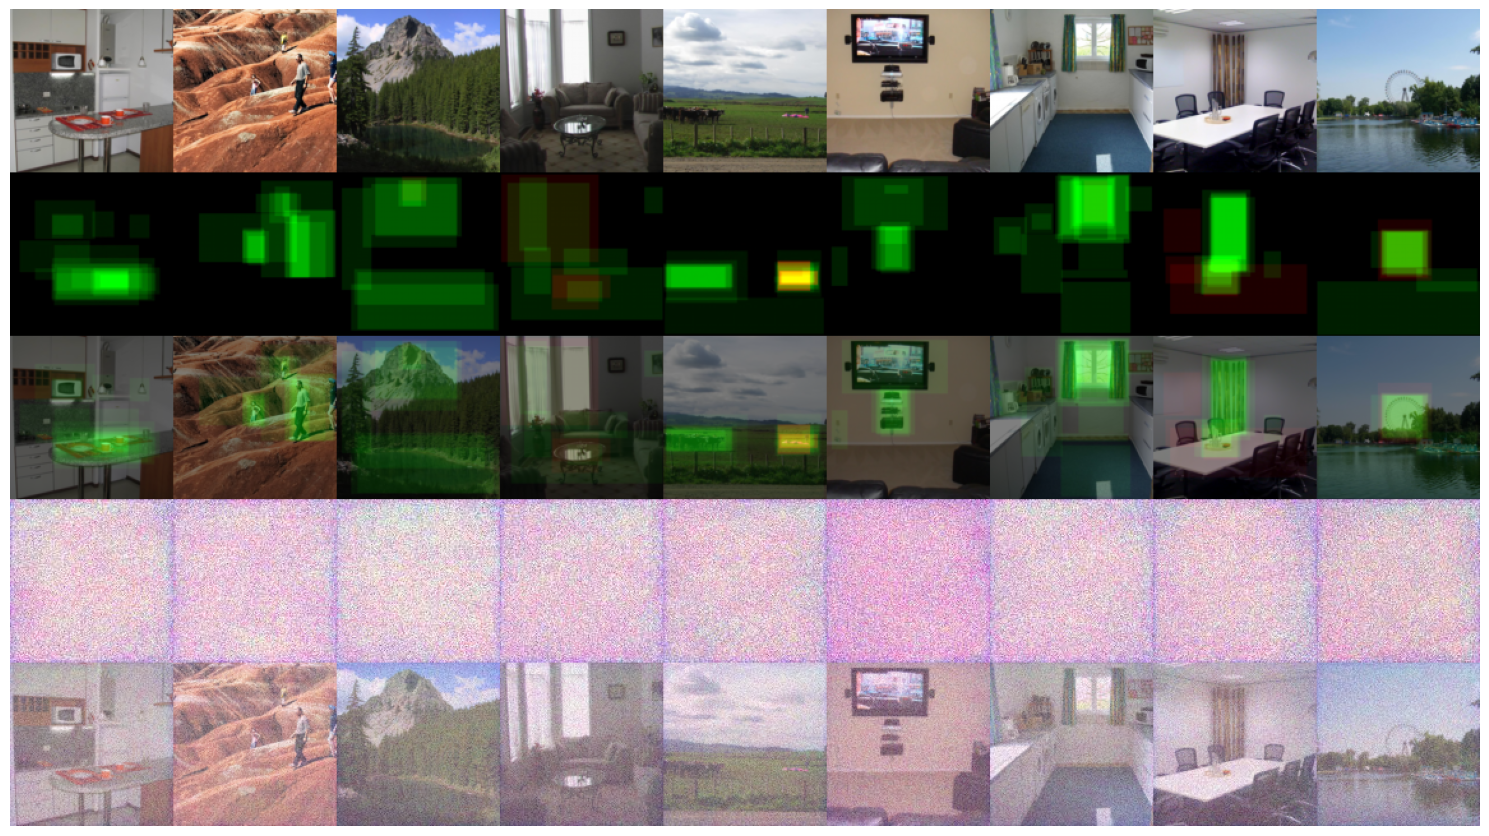

In [33]:
# Display boilerplate
figure = plt.figure(figsize=(15,15))
cols, rows = 9, 1

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(128, antialias=True),
    transforms.Normalize(0.5,0.5)
])


# Show the best
for i in range(cols):
    
    image_path   = worst_image_scores[i][0]
    print(f"image: {worst_image_scores[i][0]} loss: {worst_image_scores[i][1]}")
    image        = image_transforms(Image.open(f"../VISCHEMA_PLUS/images/{image_path}").convert("RGB"))
    label        = image_transforms(Image.open(f"../VISCHEMA_PLUS/vms/{image_path}").convert("RGB"))
    output       = image_transforms(Image.open(f"Results/{run_name}/Out_{image_path}").convert("RGB"))

    image, label, output = image[None, :], label[None, :], output[None, :]

    ideal        = torch.add(image, label)/2
    output_cat   = torch.add(image, output)/2

    if i == 0:
        display = torch.cat([
            image.to("cpu"), 
            label.to("cpu"), 
            ideal.to("cpu").detach(), 
            output.to("cpu").detach(), 
            output_cat.to("cpu").detach()
            ], dim=2)
    else:

        display = torch.cat([
            display, 
            torch.cat([
                image.to("cpu"), 
                label.to("cpu"), 
                ideal.to("cpu").detach(), 
                output.to("cpu").detach(), 
                output_cat.to("cpu").detach()
                ], dim=2)
            ], dim = 3)

display = ((display +1 ) /2).clip(0,1)        
plt.axis("off")
plt.imshow(display[0].squeeze().permute(1, 2, 0)) 
plt.tight_layout()
plt.show()